In [47]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick


from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### getting list of different metros zips to split model if necessary 

In [2]:
# lists of relevent zipcodes
target_zips = pd.read_csv('target.csv', index_col = 0)
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())


#### Loading and processing data to put into model

In [3]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )
#'new_feature'
# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa',#'new_feature'
       ],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', #'new_feature'
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)


#### Adding net approve feature.

In [4]:
merged_df['tx_net_approve_12_month_shift'] = (merged_df['tx_is_better_12_month_shift'] - 
                                              merged_df['tx_is_worse_12_month_shift'])


#### Features to put into model. Splitting test, train, forecast

In [5]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    
]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train_all = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
train_non_houston = train_all.loc[~train_all['zip_code'].isin(houston_zips_list),:]
post_train_all = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# test will have all zips. 
test = post_train_all.loc[post_train_all['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
test_houston = test.loc[test['zip_code'].isin(houston_zips_list),:]
test_non_houston = test.loc[~test['zip_code'].isin(houston_zips_list),:]
forecast = post_train_all.loc[post_train_all['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train_non_houston[X_vals]
X = scaler.fit_transform(X)
y = train_non_houston[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# test second
X_test_non_houston = test_non_houston[X_vals]
X_test_non_houston = scaler.transform(X_test_non_houston)
y_test_non_houston = test_non_houston[y_val]
# test second
X_test_houston = test_houston[X_vals]
X_test_houston = scaler.transform(X_test_houston)
y_test_houston = test_houston[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)


#### Construct model

In [6]:
lasso = Lasso(max_iter = 50000, random_state = 33)
alphas = [0.1,0.2,0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=5,n_jobs = -1, verbose=3,
                  scoring = 'neg_root_mean_squared_error')
# training on all non Houston zipcodes
clf.fit(X, y)

print(f"Best alpha {clf.best_params_['alpha']}")

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


#### Creating Coefficients of Model

In [7]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
unselected_coef_df = coef_df[coef_df['coefs']==0]
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,245.193825,245.193825
1,zori_ssa_1_diff_lag_12,22.652993,22.652993
2,zori_ssa_6_diff_lag_12,-16.088412,16.088412
3,housing_units_over_50_units_36_month_shift,-5.164245,5.164245
4,zori_ssa_12_diff_lag_12_per,4.604000,4.604000
5,black_pop_48_month_shift,4.251199,4.251199
6,housing_units_built_1960_to_1969_36_month_shift,3.537142,3.537142
7,Gross Value Natural Gas Production_annual_pct_...,-3.511190,3.511190
8,children_annual_pct_change_48_month_shift,-2.923111,2.923111
9,total_sales_tax_12_month_shift,-1.472679,1.472679


####  testing houston zipcodes on the model with no houston in the training

In [8]:
y_pred_test = clf.predict(X_test_houston)

rms = mean_squared_error(y_test_houston, y_pred_test, squared=False)
rms


38.46610085262488

####  testing non houston zipcodes on the model with no houston in the training

In [9]:
y_pred_test = clf.predict(X_test_non_houston)

rms = mean_squared_error(y_test_non_houston, y_pred_test, squared=False)
rms

52.84331132978082

####  testing all zipcodes on the model with no houston in the training

In [10]:
y_pred_test = clf.predict(X_test)

test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

rms = mean_squared_error(y_test, y_pred_test, squared=False)
rms


50.46817923584901

####  Feeding forecast values into model

In [11]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore


#### Construct timeline of zori and what prediciton status they are.

In [12]:
# put actual data into correct format
zori_pred_act = zri[['Time','zip_code','zori_ssa']].dropna(subset=['zori_ssa'])
zori_pred_act['model_code'] = 'actual_values'
# put train into correct format
zori_pred_train = test[['Time','zip_code','pred']]
zori_pred_train.columns = ['Time','zip_code','zori_ssa']
zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
# put forecast into correct format
zori_pred_fore = forecast[['Time','zip_code','pred']]
zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
zori_pred_fore['model_code'] = 'lasso_base'
# concat them together
zori_pred = pd.concat([zori_pred_act, zori_pred_train, 
                       zori_pred_fore]).reset_index(drop=True)


<ipython-input-12-b99144285d7b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
<ipython-input-12-b99144285d7b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_fore['model_code'] = 'lasso_base'


<ipython-input-48-a8e77ac790a3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['month'] = graph_df['Time'].dt.month
<ipython-input-48-a8e77ac790a3>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1%}'.format(x) for x in vals])


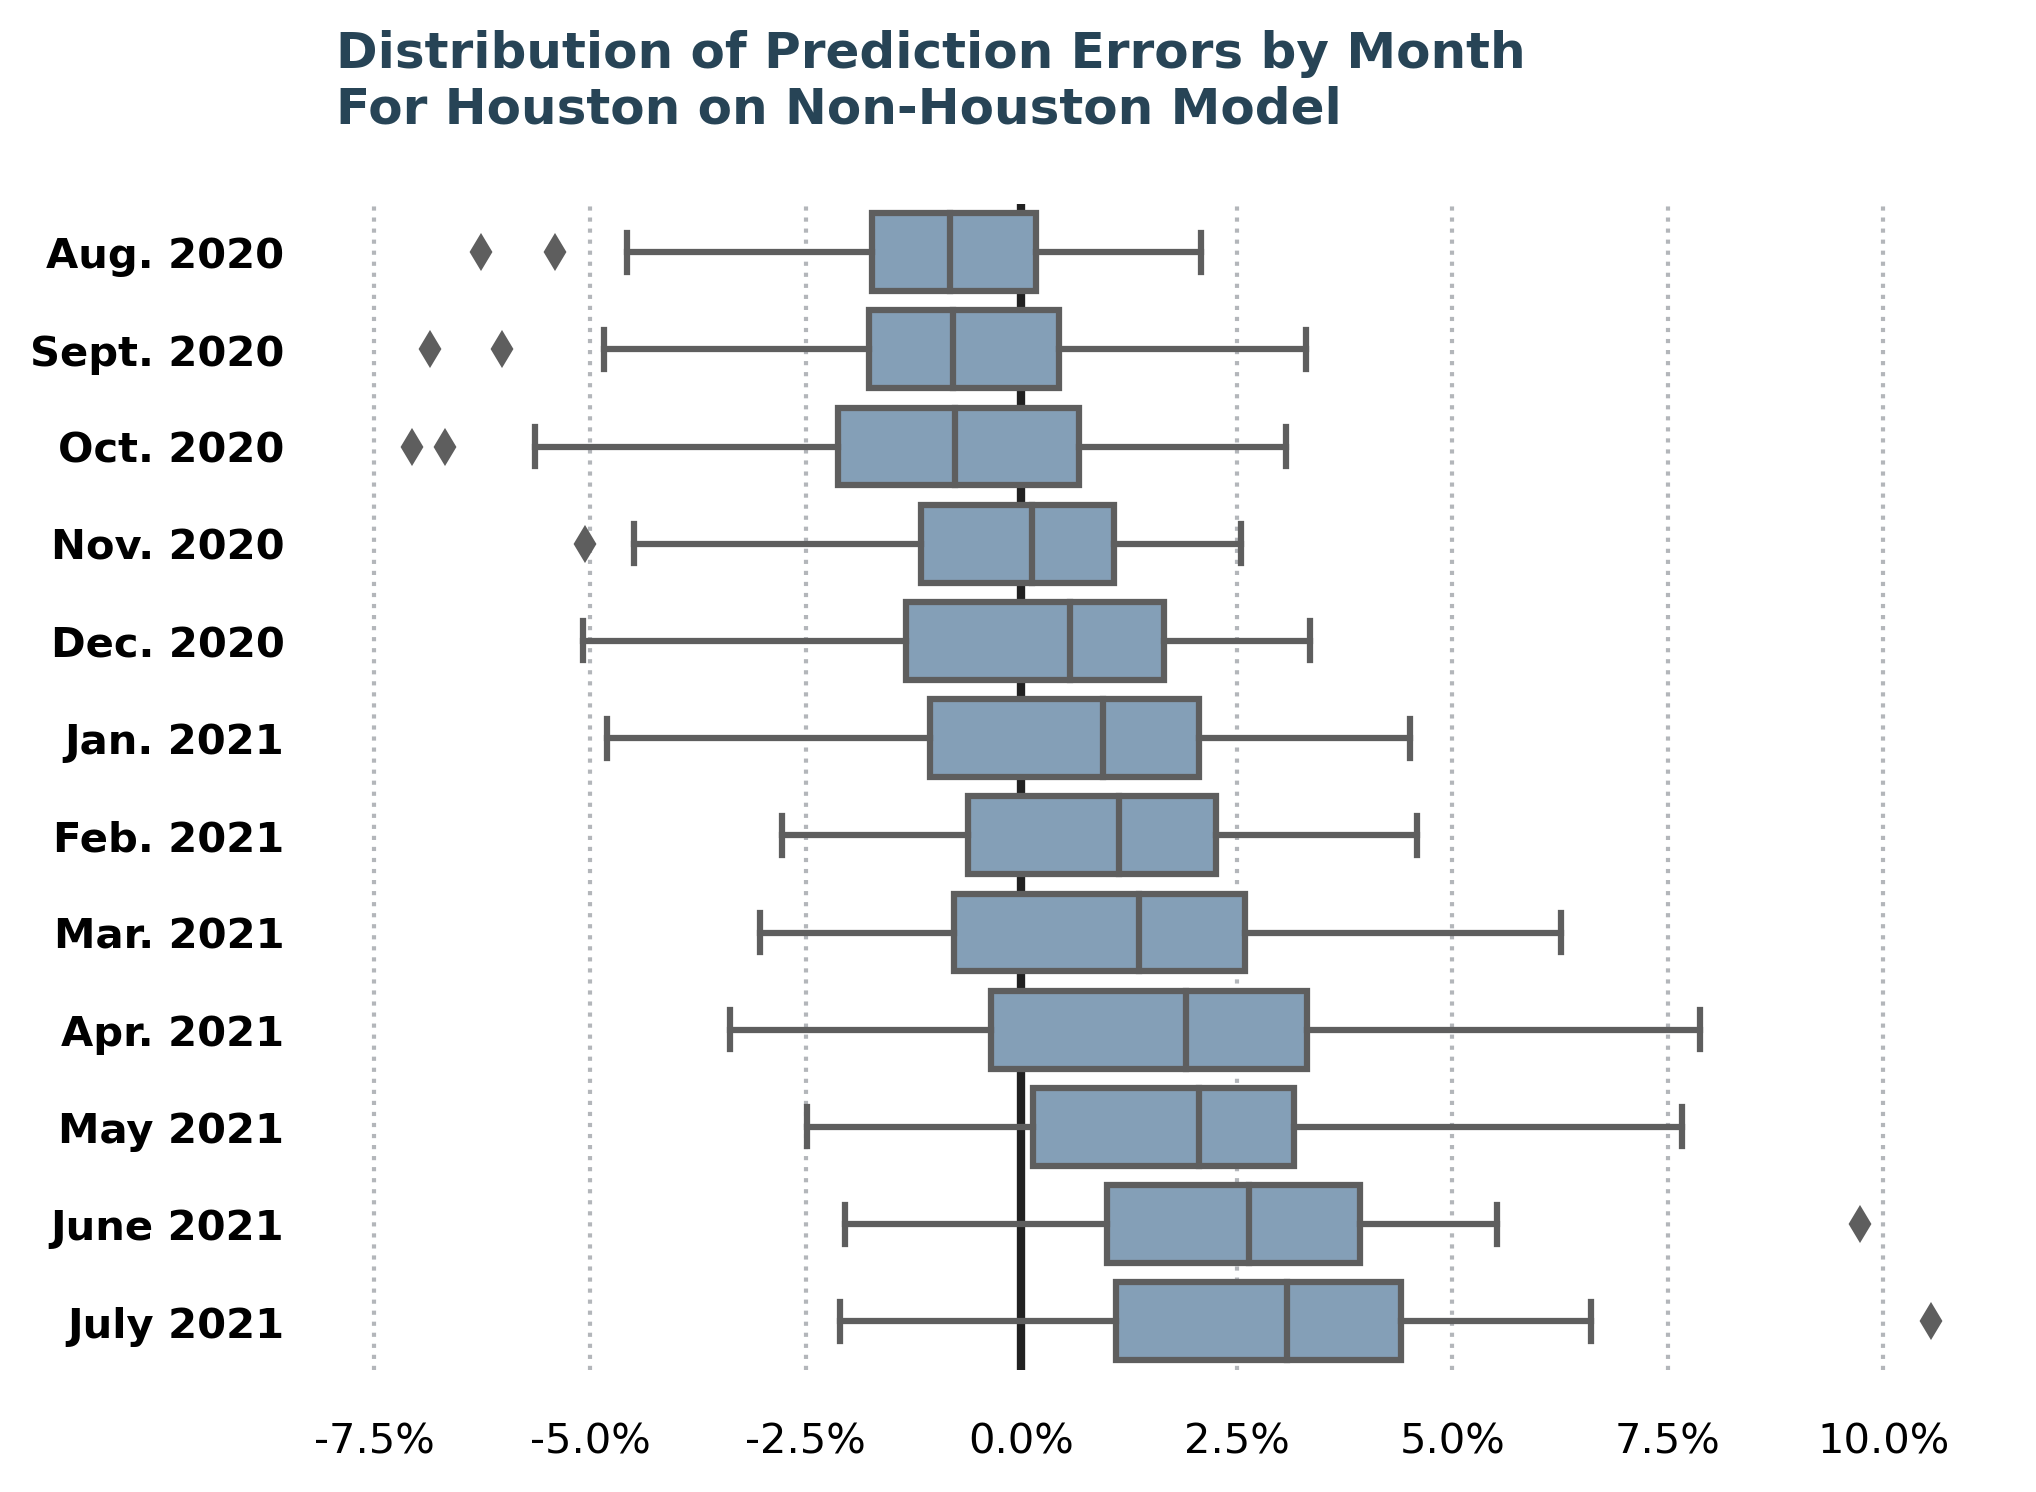

In [48]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']

graph_df = test.loc[test['zip_code'].isin(houston_zips_list),:]


graph_df['month'] = graph_df['Time'].dt.month
colors2 = ['#274456','#7BA0C0']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'Time',x = 'pred_difference_per', 
                color = colors2[1], ax = ax)
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
plt.yticks(fontweight='bold')

# set labels
g.set_yticklabels(labels = [
    'Aug. 2020', 'Sept. 2020', 'Oct. 2020', 'Nov. 2020',
    'Dec. 2020', 'Jan. 2021', 'Feb. 2021', 'Mar. 2021', 'Apr. 2021',
    'May 2021', 'June 2021', 'July 2021'
])



# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Prediction Errors by Month\nFor Houston on Non-Houston Model\n')

# adding a vertical line at 0 percent growth
blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

# g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

vals = ax.get_xticks()
ax.set_xticklabels(['{:.1%}'.format(x) for x in vals])


plt.show()



In [43]:
vals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

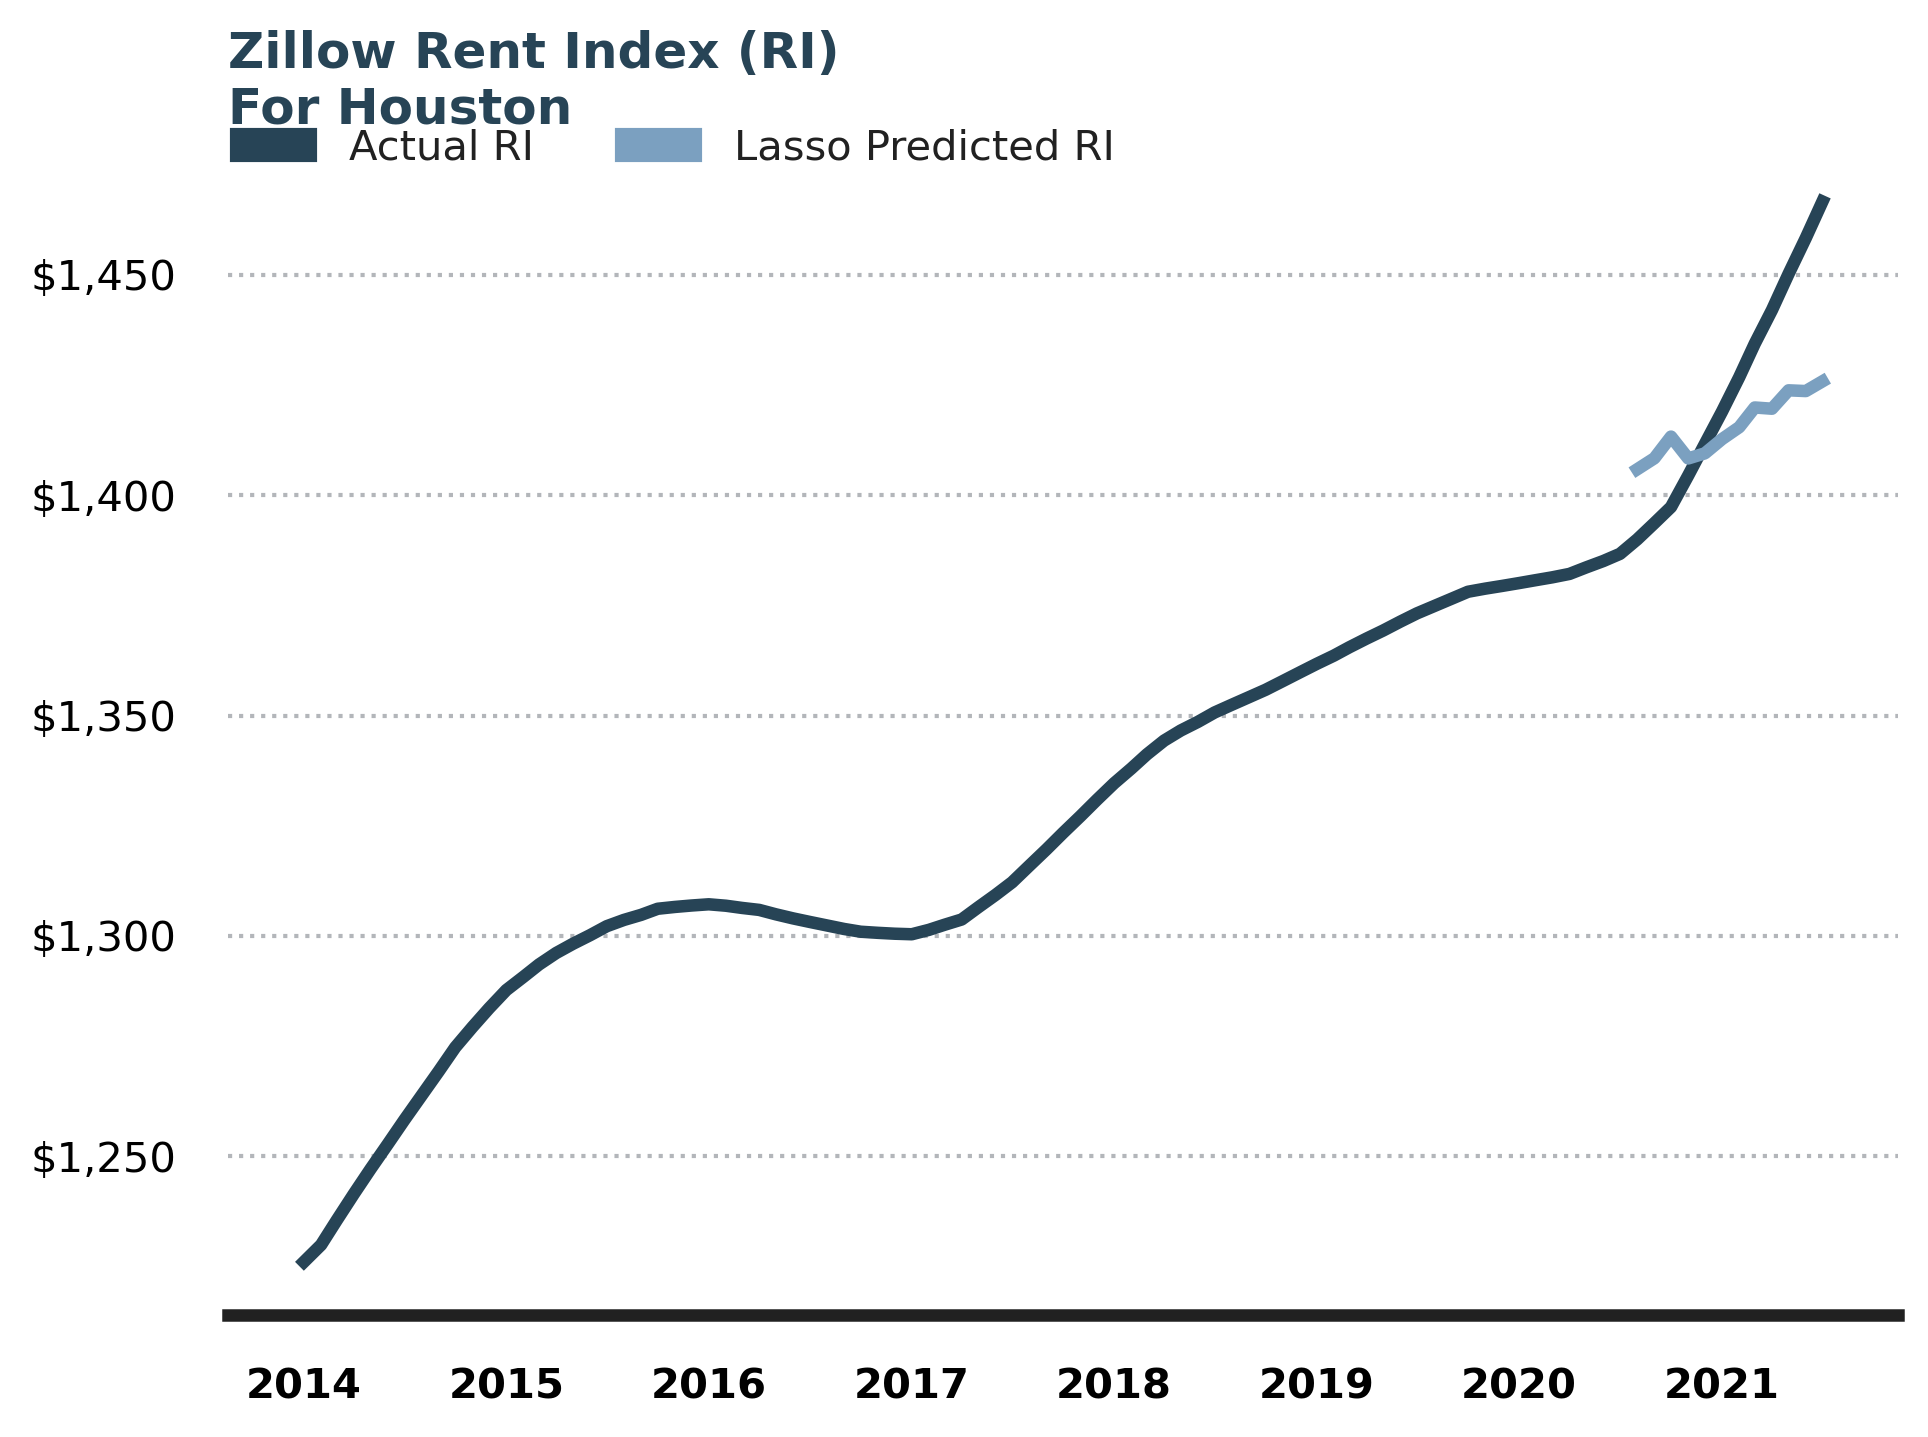

In [24]:
graph_df = zori_pred.loc[zori_pred['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)


graph_df = graph_df.loc[graph_df['zip_code'].isin(houston_zips_list),:]
colors = ['#274456','#7BA0C0']
fig, ax = plt.subplots()
g = sns.lineplot(data = graph_df, 
                 x = 'Time',y = 'zori_ssa', 
                 hue = 'model_code', ci = None, linewidth=3,
                ax = ax, 
                 palette = colors
                )
# axis spine options are ['left','right','bottom','top']
ax.spines['bottom'].set_visible(True)
# make the highlighted features bold. should be the same side with the visible spine
plt.xticks(fontweight='bold')
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'x')

g.set(xlabel='', ylabel='',title=f'Zillow Rent Index (RI)\nFor Houston ')

# # legend
acutal_patch = mpatches.Patch(color=colors[0], 
                           label='Actual RI')
lasso_patch = mpatches.Patch(color=colors[1], 
                           label='Lasso Predicted RI')
# rf_patch = mpatches.Patch(color=colors[2], 
#                            label='Random Forrest Predicted RI')
# xg_patch = mpatches.Patch(color=colors[3], 
#                            label='XGBoost Predicted RI')
plt.legend(handles=[acutal_patch,lasso_patch],
           loc='center left', 
           bbox_to_anchor=(-0.02, 1),frameon=False,ncol=2,
                title = '')

ax.yaxis.set_major_formatter('${x:,.0f}')

plt.show()